In [10]:
import scipy.fftpack as fftpack
import librosa
import pyworld as pw
import numpy as np
import os
import soundfile as sf
import fnmatch
import matplotlib.pyplot as plt
import pysptk
from librosa.display import specshow
import copy
import IPython.display as ipd

In [12]:
y, sr = sf.read('data/cut_raw/nitech_jp_song070_f001_040_1.raw', subtype='PCM_16', channels=1, samplerate=48000,
                 endian='LITTLE', start=56640, stop=262560)

sf.write('data/gen_wav/temp.wav', y, sr)
ipd.Audio('data/gen_wav/temp.wav') 

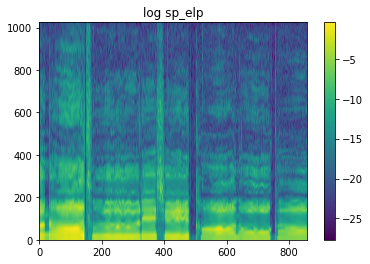

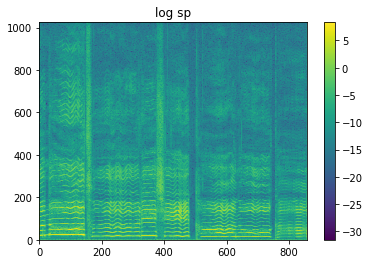

In [52]:
# 使用DIO算法计算音频的基频F0
_f0, t = pw.dio(y, sr, f0_floor=50.0, f0_ceil=800.0, channels_in_octave=2, frame_period=pw.default_frame_period)

# 使用CheapTrick算法计算音频的频谱包络 返回值是 squared mgnitude
sp_elp = pw.cheaptrick(y, _f0, t, sr)

plt.imshow(np.log(np.transpose(sp_elp)), aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('log sp_elp')
plt.show()

# 使用stft处理音频，hop_length = 5ms* sr  5ms是world默认的hop
D = np.square(np.abs(librosa.stft(y, hop_length=240)))

plt.imshow(np.log(D), aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('log sp')
plt.show()

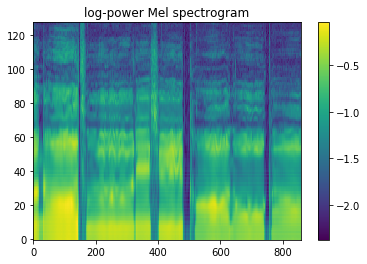

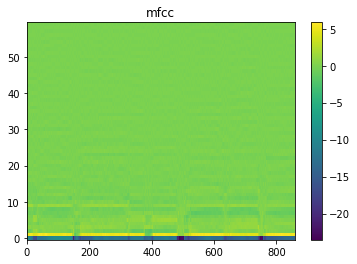

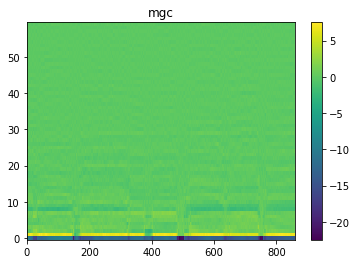

In [114]:
# 使用sp envelope 计算 mfcc
S = librosa.feature.melspectrogram(S=np.log(sp_elp.T), n_mels=128)
#S = np.log(sp_elp.T)

plt.imshow(S, aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('log-power Mel spectrogram')
plt.show()

# S: log-power Mel spectrogram
mfcc = librosa.feature.mfcc(S=S, n_mfcc=60)

plt.imshow(mfcc, aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('mfcc')
plt.show()
#print(mfcc)

order = 60
mcepInput = 3  # 0 for dB, 3 for magnitude
alpha = 0.45
fftlen = (sp.shape[1] - 1) * 2
en_floor = 10 ** (-80 / 20)

# 使用sp envelope 计算 mgc（mcep）  计算mgc没有用到mel filter bank 较好的保留了信息并且还能降低维度 一般TTS使用mgc特征
mgc = np.apply_along_axis(pysptk.mcep, 1, sp_elp, order - 1, alpha, itype=mcepInput, threshold=en_floor)

#sptk_mfcc = np.apply_along_axis(pysptk.mfcc, 1, np.log(sp_elp), order - 1, sr, num_filterbanks=order)
#print(sptk_mfcc)
plt.imshow(mgc.T, aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('mgc')
plt.show()
#print(mcep.T)

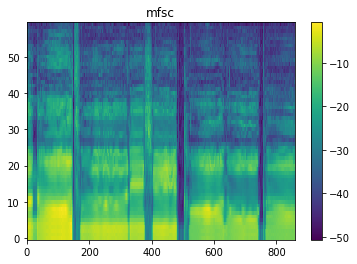

In [115]:
# 获取mfsc: mirror cepstrum, scale DC and Nyquist by 2, take real FFT
scale_mceps = copy.copy(mgc)
scale_mceps[:, 0] *= 2
scale_mceps[:, -1] *= 2
mirror = np.hstack([scale_mceps[:, :-1], scale_mceps[:, -1:0:-1]])
mfsc = np.fft.rfft(mirror).real


plt.imshow(mfsc.T, aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('mfsc')
plt.show()


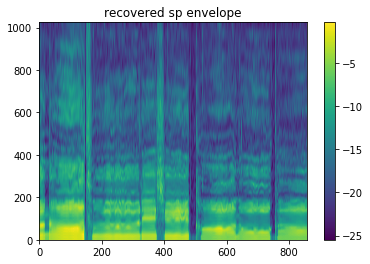

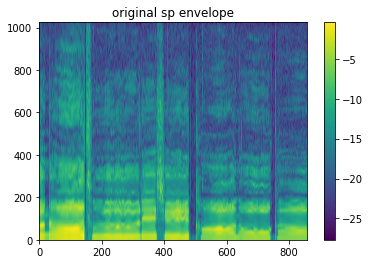

In [122]:
# 还原sp envelope 
mceps_mirror = np.fft.irfft(mfsc)
mceps_back = mceps_mirror[:, :60]
mceps_back[:, 0] /= 2
mceps_back[:, -1] /= 2

#get sp
spSm = np.exp(np.apply_along_axis(pysptk.mgc2sp, 1, mceps_back, alpha, gamma, fftlen=2048).real)

plt.imshow(np.log(spSm.T), aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('recovered sp envelope')
plt.show()

plt.imshow(np.log(np.transpose(sp_elp)), aspect='auto', origin='bottom', interpolation='none')
plt.colorbar()
plt.title('original sp envelope')
plt.show()